In [40]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
df = pd.read_csv("./data_raw/3_moons.csv")
del df["Label"]
df.head()

,Feature1,Feature2
0,0.771744,-0.548086
1,0.189416,-0.261982
2,0.918359,0.443277
3,1.021213,-0.488523
4,1.178442,-0.369193


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Feature1  300 non-null    float64
 1   Feature2  300 non-null    float64
dtypes: float64(2)
memory usage: 4.8 KB


In [43]:
df.shape

(300, 2)

In [44]:
df.describe()

,Feature1,Feature2
count,300.000000,300.000000
mean,0.488043,0.239049
std,0.869298,0.516869
min,-1.199514,-0.712647
25%,-0.059999,-0.235778
50%,0.504404,0.259209
75%,1.093912,0.679978
max,2.258751,1.225172


In [45]:
df.duplicated().sum()

np.int64(0)

In [46]:
df.isnull().sum()

Feature1    0
Feature2    0
dtype: int64

# Analyse Univariée

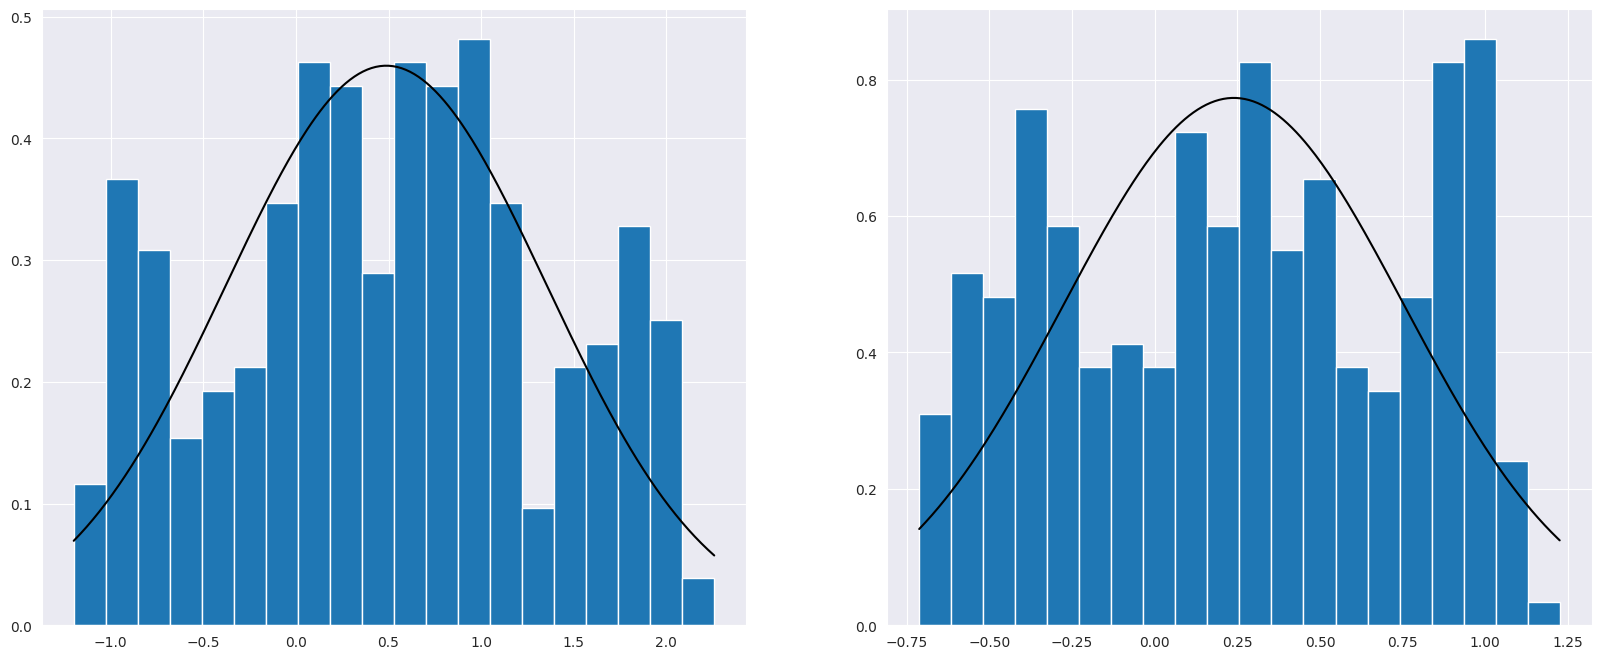

In [47]:
from scipy.stats import norm

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for column, i in zip(df.columns, range(df.shape[1])) :
    xmin, xmax = df[column].min(), df[column].max()
    mu, std = norm.fit(df[column])

    x = np.linspace(xmin, xmax, df[column].count())
    p = norm.pdf(x, mu, std)

    ax[i].hist(df[column], bins=20, density=True)
    ax[i].plot(x, p, "k")

plt.show()

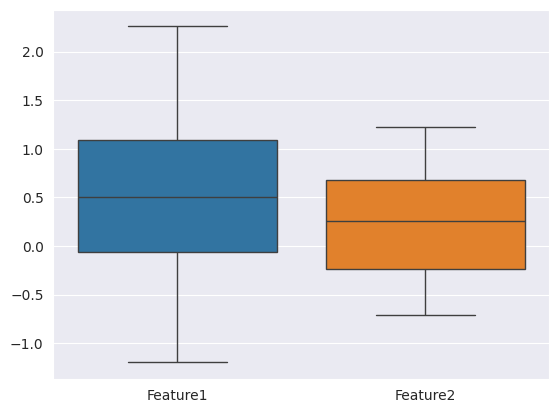

In [48]:
sns.boxplot(data=df)
plt.show()

Nos deux variables ont l'allure d'une distribution normale. En outre, nos boxplots nous indiquent que la feature1 est plus étendue autour de sa médiane, tandis que la feature2 est plus concentrée autour de sa médiane.

In [49]:
# On pourrait calculer le skewness pour voir la symétrie de nos variables
print(f"Feature1 skewness : {df["Feature1"].skew()}")
print(f"Feature2 skewness : {df["Feature2"].skew()}")

Feature1 skewness : -0.009409197894142386
Feature2 skewness : -0.055894103849484546


Nos variables ont un skewness sensiblement nul, et du coup, on peut conclure qu'elles sont symétriques. Quant à l'aplatissement, On peut le vérifier avec le kurtosis :

In [50]:
print(f"Feature1 kurtosis : {df["Feature1"].kurtosis()}")
print(f"Feature2 kurtosis : {df["Feature2"].kurtosis()}")

Feature1 kurtosis : -0.8609998468511413
Feature2 kurtosis : -1.1819953990153778


Étant tous deux négatifs, On peut déduire que nos distributions sont plus applatie et du coup sont moins concentrées.

On peut passer aux tests de normalité

- Hypothèse nulle H0 : Nos données suivent une loi normale
- Hypothèse alternative H1 : Nos données ne suivent pas une loi normale

In [51]:
stat, p_value = shapiro(df["Feature1"])
print(f"Statistic : {stat}, \t p value : {p_value}")

stat, p_value = shapiro(df["Feature2"])
print(f"Statistic : {stat}, \t p value : {p_value}")

Statistic : 0.9733201037803921, 	 p value : 2.2623233646290846e-05
Statistic : 0.953530750770691, 	 p value : 3.695248278356348e-08


La p value est inférieur au seuil de 5%, par conséquent, on rejette l'hypothèse nulle : Nos données ne suivent pas une loi normale

# Analyse Bivariée

In [52]:
# Matrice de corrélation

matrix_corr = np.corrcoef(df.Feature1, df.Feature2)
matrix_corr

array([[ 1.        , -0.43648821],
       [-0.43648821,  1.        ]])

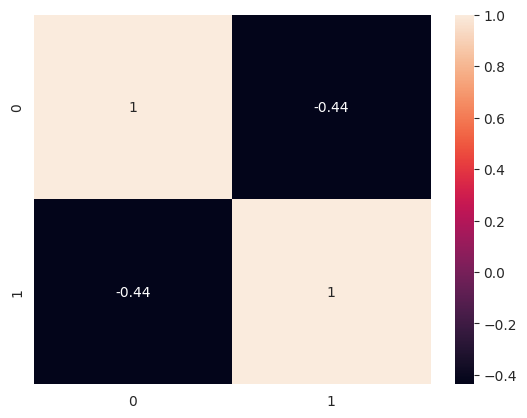

In [53]:
sns.heatmap(matrix_corr, annot=True)
plt.show()

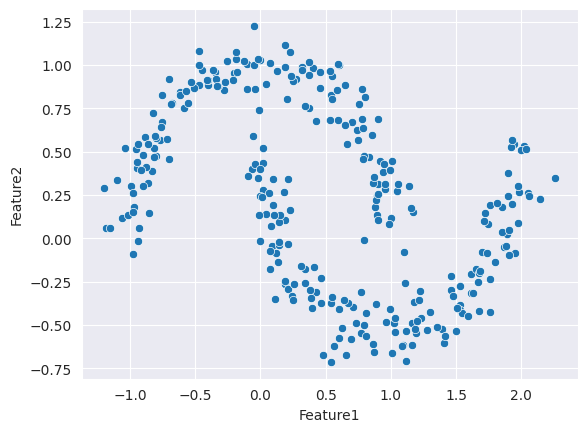

In [54]:
sns.scatterplot(df, x="Feature1", y="Feature2")
plt.show()

On voit clairement qu'il n'y a pas de lien LINÉAIRE entre nos deux variables. Mais la forme obtenue avec le scatter, montre qu'il existe quand même un lien.

Passons par spearman pour vérifier cela

- Hypothèse nulle H0 : Nos variables n'ont aucun lien entre elles
- Hypothèse alternative H1 : Nos données ont un lien entre elles

In [55]:
stat, p_value = spearmanr(df["Feature1"], df["Feature2"])
print(f"Statistic : {stat}, \t p value : {p_value}")

Statistic : -0.47195191057678415, 	 p value : 4.7879957947910095e-18


La p valeur nous permet de rejetter l'hypothèse nulle. Il existe bel et bien un lien entre ces deux variables

# Mise en place du K-means

In [56]:
from sklearn.preprocessing import StandardScaler

In [57]:
index = df.index
column = df.columns
X = df.values

In [58]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[:5]

array([[ 0.32690225, -1.52543538],
       [-0.34410024, -0.97097692],
       [ 0.49584267,  0.39578564],
       [ 0.61435899, -1.4100055 ],
       [ 0.79552923, -1.1787474 ]])

In [59]:
# Méthode du coude

inertia = []
max_cluster = 10

k_list = list(range(1, max_cluster+1))
k_list

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [60]:
from sklearn.cluster import KMeans

for i in k_list :
    k_means = KMeans(n_clusters=i)
    k_means.fit(X_scaled)
    inertia.append(k_means.inertia_)
inertia

[600.0,
 254.04621474745022,
 191.4582612455205,
 124.74976373433653,
 100.11692159499675,
 74.22448099367575,
 56.897372263697996,
 43.10656941657435,
 36.497943354334325,
 34.534362281852715]

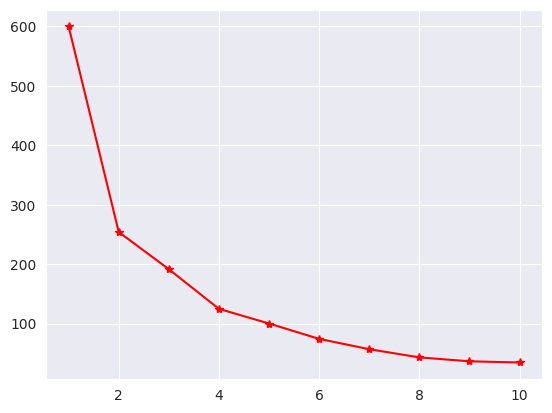

In [61]:
plt.plot(k_list, inertia, marker="*", c="red")
plt.show()

In [62]:
# On choisi 2 clusters
n_clust = 2

In [63]:
k_means = KMeans(n_clusters=n_clust)
k_means.fit(X_scaled)
labels = k_means.labels_

In [64]:
df["k_clusters"] = labels

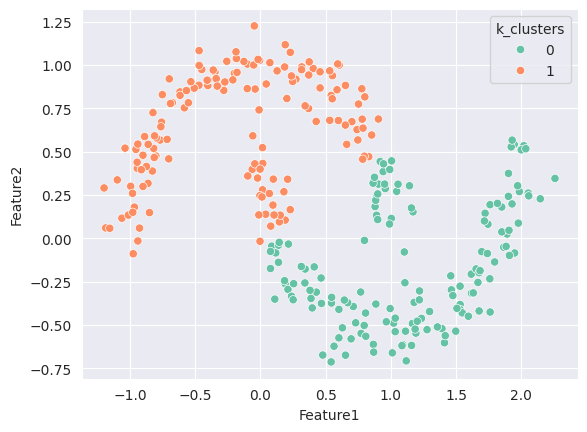

In [65]:
sns.scatterplot(df, x="Feature1", y="Feature2", hue="k_clusters", palette=sns.color_palette("Set2")[:n_clust])
plt.show()

# Classification Hiérarchique

In [66]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [67]:
def plot_dendrogram(Z, labels=None,
                    figsize=(30, 15),
                    title="Hierarchical Clustering Dendrogram",
                    x_label="Distances", y_label="Clusters",
                    orientation="top" ) :
    """
    Affiche un dendrogramme horizontal à partir d'une matrice de linkage déjà calculée

    Paramètres :
    ------------
    Z : array-like
        Matrice de linkage obtenue via scipy.cluster.hierarchy.linkage.
    labels : list ou None
        Noms à afficher sur les feuilles du dendrogramme.
    figsize : tuple
        Taille de la figure (largeur, hauteur).
    title : str
        Titre du graphique
    orientation : str
        Orientation du dendogramme.
    """

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    dendrogram(
        Z,
        ax=ax,
        labels=labels,
        orientation=orientation,
        leaf_font_size=15
    )

    plt.title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    ax.tick_params(axis='x', which='major', labelsize=15)
    ax.tick_params(axis='y', which='major', labelsize=15)

    plt.tight_layout()
    plt.show()

In [68]:
Z = linkage(X_scaled, method="ward", metric="euclidean")

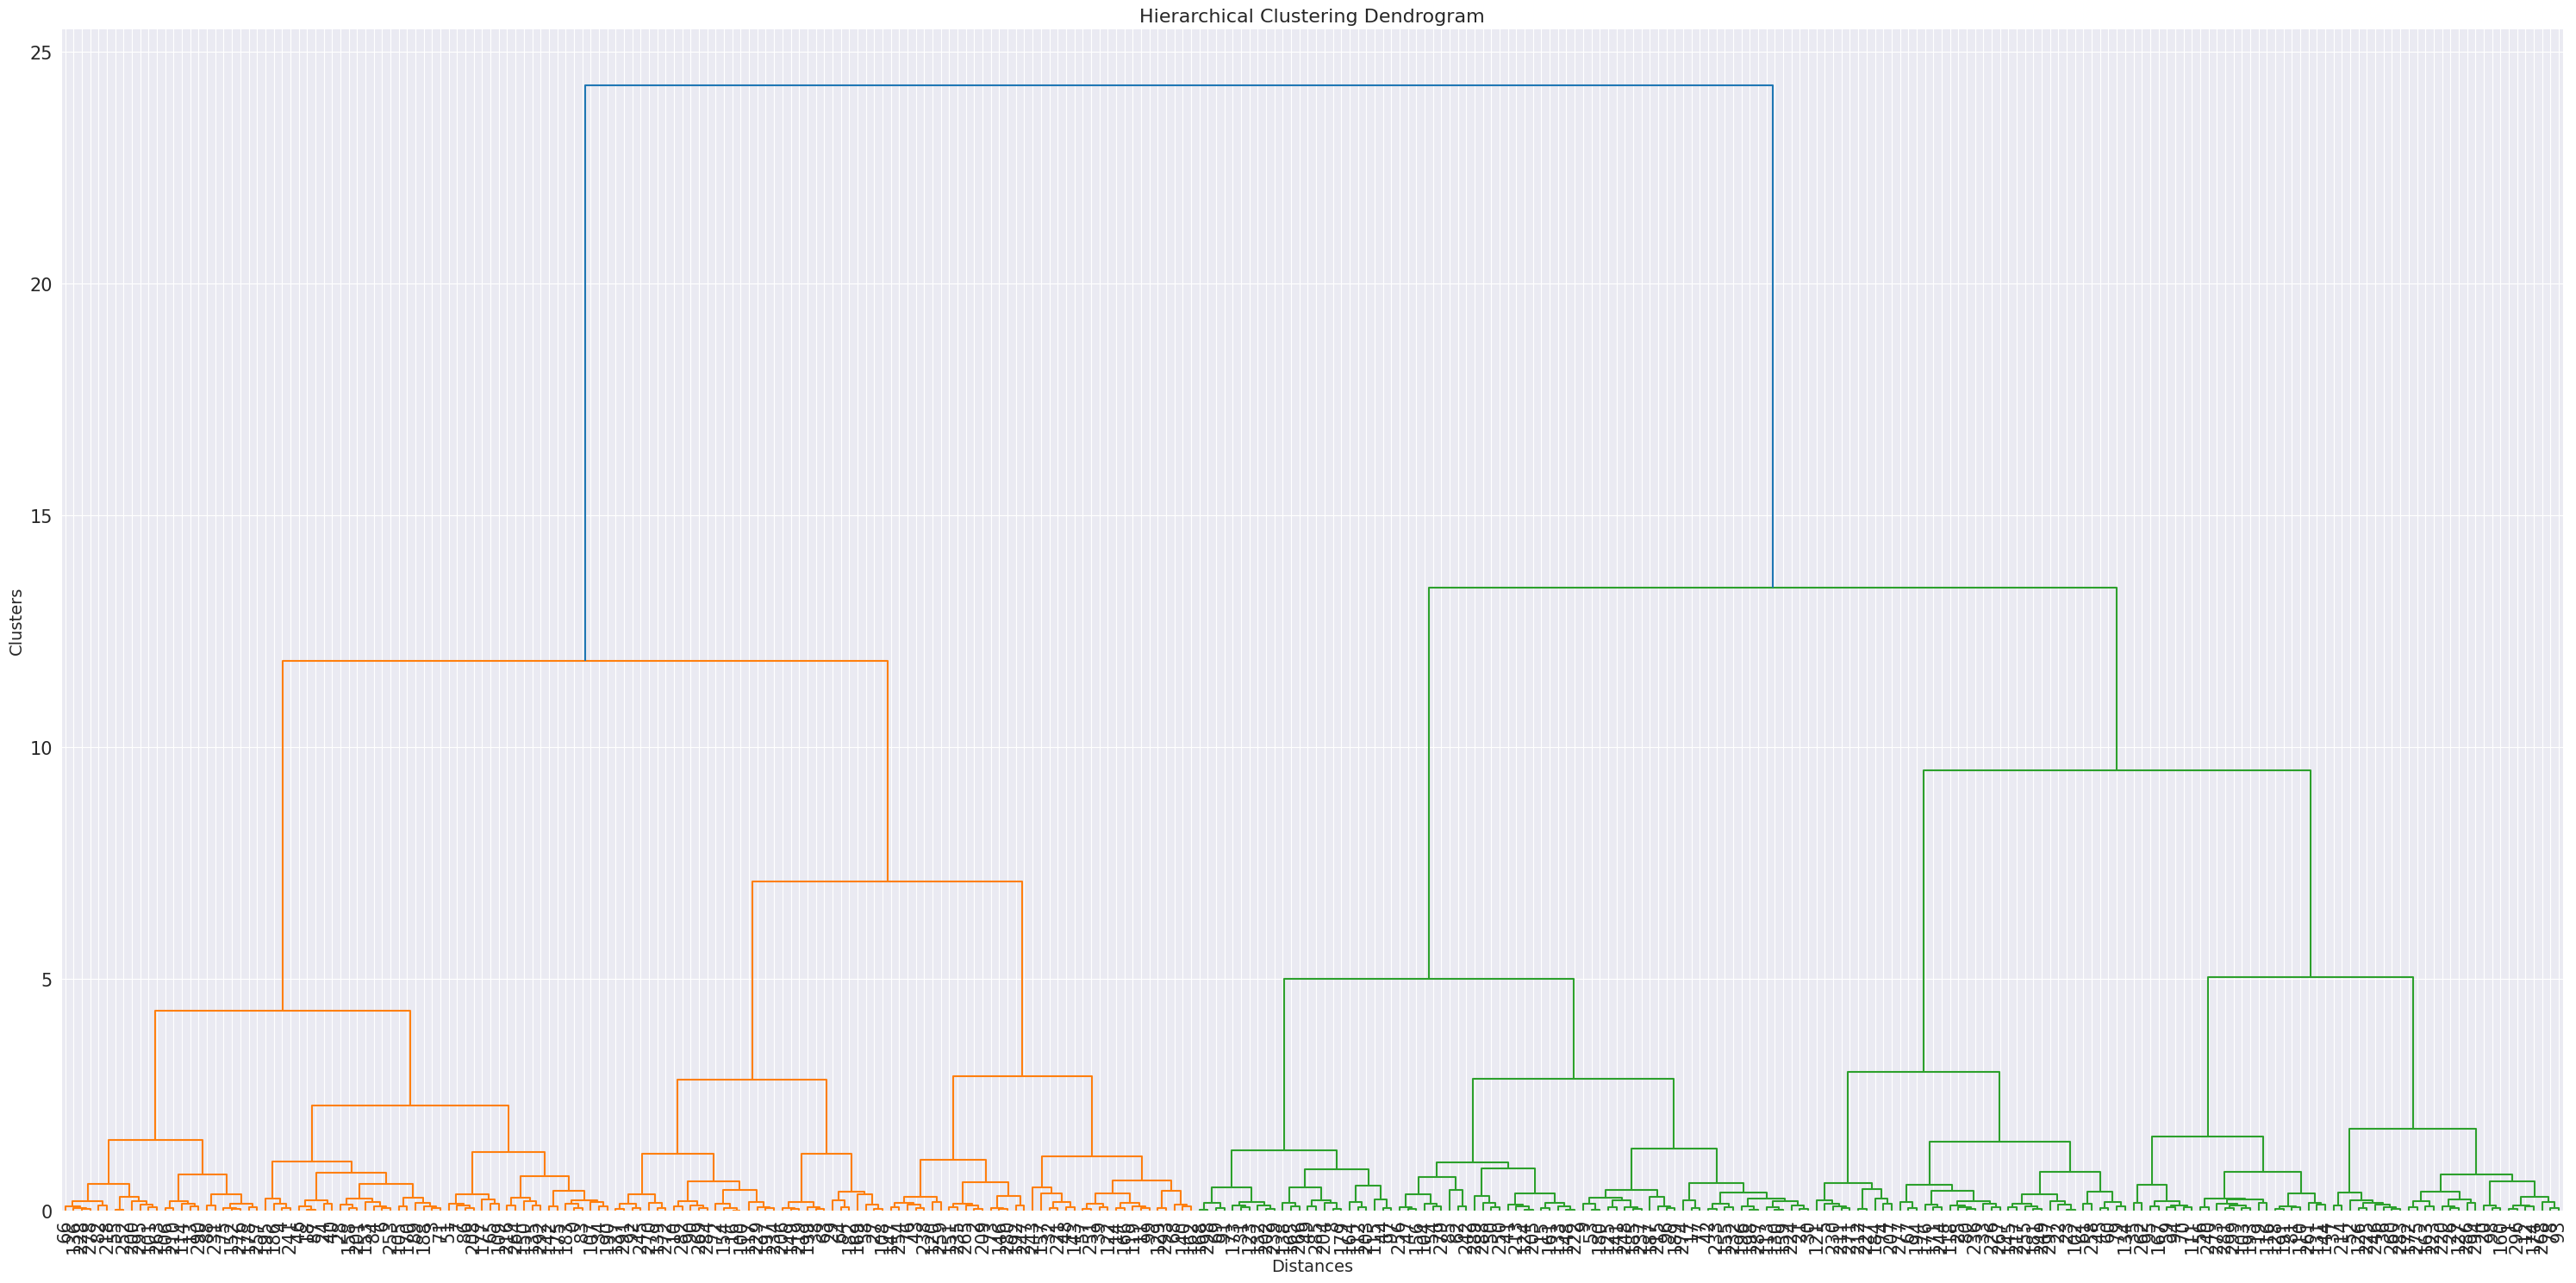

In [69]:
plot_dendrogram(Z, labels=index)

In [70]:
silhouette_scores = []

cah_list = list(range(2, max_cluster+1))
cah_list

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [71]:
from sklearn.metrics import silhouette_score

for i in cah_list :
    clusters = fcluster(Z, t=i, criterion="maxclust")
    silhouette_avg = silhouette_score(X_scaled, clusters)
    silhouette_scores.append(silhouette_avg)
silhouette_scores

[0.4116176745295905,
 0.38987169389385345,
 0.4029560324942135,
 0.45330660565000985,
 0.4791210670701708,
 0.475329307308401,
 0.4656341462623057,
 0.4572269846056447,
 0.4506365212698024]

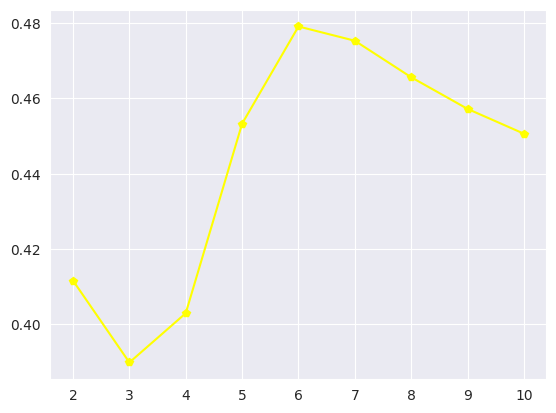

In [72]:
plt.plot(cah_list, silhouette_scores, marker="p", color="yellow")
plt.show()

In [73]:
# On prendra 6 clusters
n_clust = 6

In [74]:
clusters = fcluster(Z, t=n_clust, criterion="maxclust")
df["cah_cluster"] = clusters

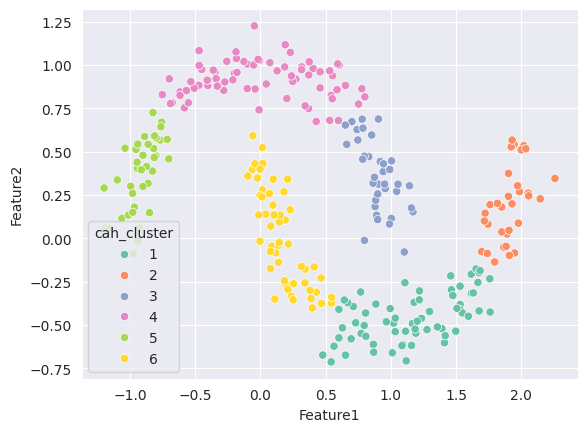

In [75]:
sns.scatterplot(df, x="Feature1", y="Feature2", hue="cah_cluster", palette=sns.color_palette("Set2")[:n_clust])
plt.show()

Sur cet exercice le K-means nous a permis d'avoir de meilleurs clusters que la CAH.